In [1]:
# Author: Ruoyu Lin
# Docstring style: Sphinx

from fred_query import get_all_series
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

TICKERS = ["GS"+str(n) for n in [1, 2, 3, 5, 7, 10]]
N = len(TICKERS)

# Part I: Data Loading and Dimensionality Reduction

## Data Loading and transforming

In [2]:
# Use query code to load data in a dataframe
df = get_all_series(TICKERS, as_ret=True)

# In standard practice, we demean the data before fit for stability
df = df.apply(lambda x: x - x.mean())

# Get data matrix
val = df.values

## Define model and preliminary fitting

In [3]:
# Define model and fit model
model = PCA()
model.fit(val)

PCA()

explained_variance_ratio:
[8.43055555e-01 1.24200865e-01 2.62989971e-02 4.91197940e-03
 1.08674234e-03 4.45861871e-04]


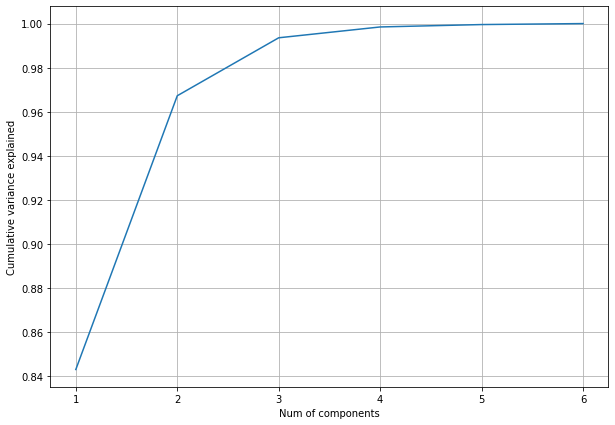

In [4]:
print("explained_variance_ratio:")
print(model.explained_variance_ratio_)
fig, ax = plt.subplots(figsize = [10,7])
ax.plot(list(range(1,N+1)), np.cumsum(model.explained_variance_ratio_))
ax.set_xlabel("Num of components")
ax.set_ylabel("Cumulative variance explained")
ax.grid()
plt.show()

In [5]:
# The first two components explains over 96.7% of all variances in the multi-series.
# Set limit of components to 2 
transformed = model.transform(val)[:, :2]

The above transformation has hence reduced dimension of the original data from 6 to 2, with reasonable loss of information.

# Part II: time-stability analysis

PCA's function can essentially be viewed as a "de-noising" maneuver on the original data: we pick the number of dimensions we keep, and the rest we view as noise. 

Intuition: since the components kept explain most variance in the original data, it as well retains most information in the original data, which means that the OLS residual, the information in the original data unexplained by the chosen components, of the original series on the chosen components would be low. 

Then it follows that, if the PCA is time-stable, the OLS residual would be homoskedastic i.e. the variance of the residual does not demonstrate variation through time. We thus run Bresuch-Pagan tests for heteroskedasticity on the OLS residuals of each series on the PCs chosen, and use the test p-value as a metric for time stability. In terms of statistics, we have

\begin{align}
    H_0:\quad &\text{Constant variance in error term}\\
    H_1:\quad &\text{Otherwise}
\end{align}

and we use a $\alpha =0.05$ critical value as cutoff

In [6]:
df.loc[:,"pca1"] = transformed[:,0]
df.loc[:,"pca2"] = transformed[:,1]

In [7]:
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

def bresuch_pagan(col, data): # for our usage only. Not general. 
    """Run Bresuch-Pagan test for heteroskedasticity of a col on PCs.
    Returns the p-value of the Bresuch-Pagan test.
    
    :param col: column name in TICKERS
    :type col: str
    :param data: TICKERS data and chosen PCs
    :type data: pd.DataFrame
    :rtype: float
    """
    fit = smf.ols(f"{col} ~ pca1+pca2", data).fit()
    names = ['p-value']
    test = sms.het_breuschpagan(fit.resid, fit.model.exog)
    return lzip(names, test)[0][1]


In [8]:
P_VALUE_THRESHOLD = 0.01

for series in TICKERS:
    bp_pval = bresuch_pagan(series, df)
    homoskedastic = (bp_pval <= P_VALUE_THRESHOLD)
    print(f"Testing for heteroskedasticity for series [{series}]:")
    print(f"p-value: {bp_pval}")
    print(f"Homoskedastic/time-stable: {homoskedastic}.")
    print()

Testing for heteroskedasticity for series [GS1]:
p-value: 15.61152629284448
Homoskedastic/time-stable: False.

Testing for heteroskedasticity for series [GS2]:
p-value: 33.604254843792916
Homoskedastic/time-stable: False.

Testing for heteroskedasticity for series [GS3]:
p-value: 9.838094787497237
Homoskedastic/time-stable: False.

Testing for heteroskedasticity for series [GS5]:
p-value: 88.60757808437266
Homoskedastic/time-stable: False.

Testing for heteroskedasticity for series [GS7]:
p-value: 6.084980639930798
Homoskedastic/time-stable: False.

Testing for heteroskedasticity for series [GS10]:
p-value: 12.108167768821001
Homoskedastic/time-stable: False.



This concludes our analysis. Our homoskedasticity test suffices to show that the PCA method is not time-stable. This is expected for the use case of PCA in financial analytics, as financial data is known for the presence of far-tail events. 